In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## MVP - Spotify song popularity predictor
### Cleaning data

For this project I am training a model using Spotify track metadata to predict a song's popularity. I have a dataset of 1277 rows and 13 features. 

In [2]:
# import data

spotify_df = pd.read_csv('/Users/joycetagal/Github/metis/reg/spotify_full_data.csv')

In [4]:
spotify_df.shape

(1277, 23)

In [3]:
spotify_df.head()

,id,popularity,duration,loudness,tempo,tempo_confidence,time_signature,time_signature_confidence,key,key_confidence,...,danceability,energy,instrumentalness,liveness,speechiness,valence,title,artist,song id,weekly chart date
0,67BtfxlNbhBmCDR2L2l8qd,93,137.87573,-6.682,178.818,0.113,4.0,1.000,8.0,0.586,...,0.610,0.508,0.000000,0.3840,0.1520,0.7580,MONTERO (Call Me By Your Name),Lil Nas X,67BtfxlNbhBmCDR2L2l8qd,2021-09-10 - 2021-09-17
1,1lNEXDlxVhsWaq2DLBUDgC,73,167.12000,-6.484,80.043,0.455,4.0,1.000,1.0,0.335,...,0.654,0.713,0.000000,0.0837,0.0846,0.6940,simple times,Kacey Musgraves,1lNEXDlxVhsWaq2DLBUDgC,2021-09-10 - 2021-09-17
2,5ScbulRnixQ2XAdvrPMFjz,81,229.30354,-6.770,177.693,0.119,3.0,1.000,8.0,0.505,...,0.320,0.466,0.000000,0.1330,0.0374,0.3380,Get Along Better,"Drake, Ty Dolla $ign",5ScbulRnixQ2XAdvrPMFjz,2021-09-10 - 2021-09-17
3,15hJmqqEtASVXl6sM7i4UF,75,270.67078,-5.620,130.027,0.225,4.0,0.896,10.0,0.435,...,0.615,0.600,0.000002,0.2830,0.2700,0.0661,trademark usa,BaKeem,15hJmqqEtASVXl6sM7i4UF,2021-09-10 - 2021-09-17
4,3RkNXZvOSMMElmmXztDc94,80,245.13103,-9.840,87.073,0.262,4.0,0.979,4.0,0.742,...,0.783,0.416,0.000000,0.1030,0.1350,0.1650,F*****g Fans,Drake,3RkNXZvOSMMElmmXztDc94,2021-09-10 - 2021-09-17


In [6]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1277 entries, 0 to 1276
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1277 non-null   object 
 1   popularity                 1277 non-null   int64  
 2   duration                   1276 non-null   float64
 3   loudness                   1276 non-null   float64
 4   tempo                      1276 non-null   float64
 5   tempo_confidence           1276 non-null   float64
 6   time_signature             1276 non-null   float64
 7   time_signature_confidence  1276 non-null   float64
 8   key                        1276 non-null   float64
 9   key_confidence             1276 non-null   float64
 10  mode                       1276 non-null   float64
 11  mode_confidence            1276 non-null   float64
 12  acousticness               1277 non-null   float64
 13  danceability               1277 non-null   float

In [17]:
spotify_df = spotify_df.dropna(axis='index') # Drop NA values
spotify_df = spotify_df.select_dtypes(exclude=['object']).copy() # Drop non-numerical columns
spotify_df = spotify_df.drop( # Drop confidence columns
    columns=['tempo_confidence', 'time_signature_confidence', 'key_confidence', 'mode_confidence'] 
)

In [18]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1276 entries, 0 to 1276
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        1276 non-null   int64  
 1   duration          1276 non-null   float64
 2   loudness          1276 non-null   float64
 3   tempo             1276 non-null   float64
 4   time_signature    1276 non-null   float64
 5   key               1276 non-null   float64
 6   mode              1276 non-null   float64
 7   acousticness      1276 non-null   float64
 8   danceability      1276 non-null   float64
 9   energy            1276 non-null   float64
 10  instrumentalness  1276 non-null   float64
 11  liveness          1276 non-null   float64
 12  speechiness       1276 non-null   float64
 13  valence           1276 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 149.5 KB


## Visualizing and exploring data

In [19]:
spotify_df.corr()

,popularity,duration,loudness,tempo,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
popularity,1.000000,0.118371,0.183157,-0.014511,0.052758,0.059334,-0.099300,-0.115256,0.081155,0.085161,0.021501,-0.078753,-0.031458,-0.048735
duration,0.118371,1.000000,0.044729,0.009761,0.015194,0.012808,0.043011,0.035640,-0.187415,0.022556,-0.012959,-0.013985,-0.086173,-0.170310
loudness,0.183157,0.044729,1.000000,0.078766,0.112790,0.033727,-0.008602,-0.529416,0.224202,0.721004,-0.181518,0.041598,0.016817,0.154396
tempo,-0.014511,0.009761,0.078766,1.000000,0.006962,-0.024737,0.000884,-0.069750,-0.045288,0.085971,-0.015068,-0.061633,0.121714,0.030680
time_signature,0.052758,0.015194,0.112790,0.006962,1.000000,0.078812,-0.051453,-0.154090,0.199745,0.177379,-0.060418,-0.050545,0.061508,0.105198
key,0.059334,0.012808,0.033727,-0.024737,0.078812,1.000000,-0.179259,-0.019881,0.067793,0.068362,0.062938,-0.010794,0.039918,0.119017
mode,-0.099300,0.043011,-0.008602,0.000884,-0.051453,-0.179259,1.000000,0.073749,-0.142209,-0.030317,-0.020911,0.026627,-0.150935,0.017034
acousticness,-0.115256,0.035640,-0.529416,-0.069750,-0.154090,-0.019881,0.073749,1.000000,-0.342112,-0.563166,0.070905,-0.016731,-0.171802,-0.096420
danceability,0.081155,-0.187415,0.224202,-0.045288,0.199745,0.067793,-0.142209,-0.342112,1.000000,0.128903,-0.106570,-0.119982,0.297346,0.289707
energy,0.085161,0.022556,0.721004,0.085971,0.177379,0.068362,-0.030317,-0.563166,0.128903,1.000000,-0.044784,0.123373,0.045206,0.324390


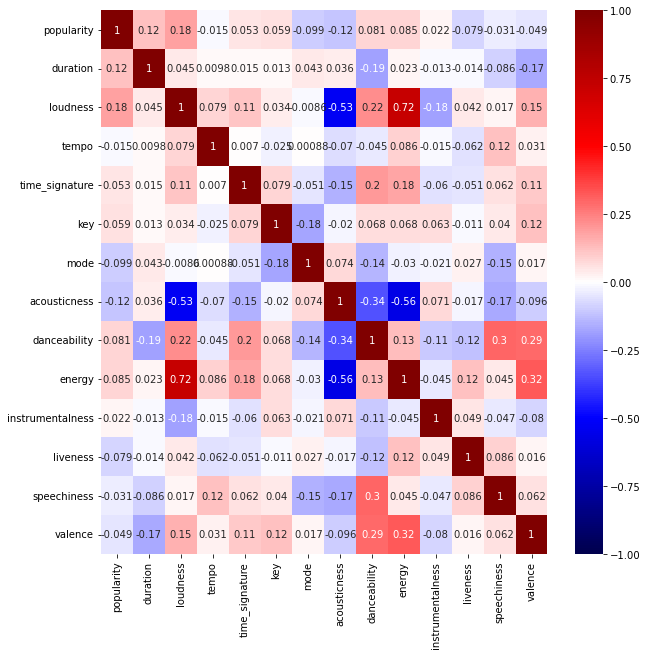

In [20]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(spotify_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [21]:
spotify_df.corr()['popularity'].sort_values(ascending=False)

popularity          1.000000
loudness            0.183157
duration            0.118371
energy              0.085161
danceability        0.081155
key                 0.059334
time_signature      0.052758
instrumentalness    0.021501
tempo              -0.014511
speechiness        -0.031458
valence            -0.048735
liveness           -0.078753
mode               -0.099300
acousticness       -0.115256
Name: popularity, dtype: float64

Simply based on the correlations plot, it looks as if the correlations for our target `popularity` are weak, with the highest correlation being `loudness` with -0.18 correlation. Let's use Seaborn to pairplot the variables with the highest correlations cores.

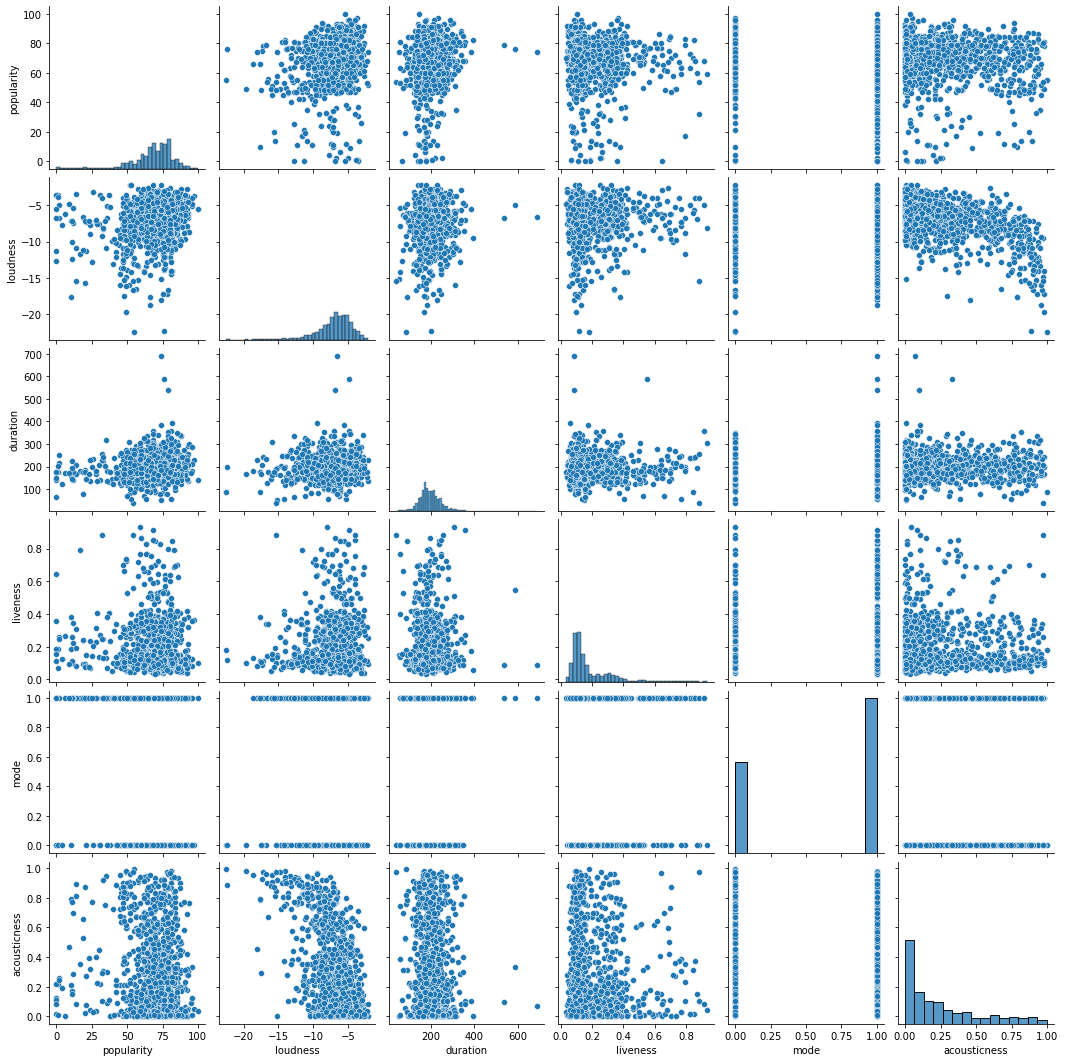

In [24]:
sns.pairplot(spotify_df[['popularity', 'loudness', 'duration', 'liveness', 'mode', 'acousticness']])

In [25]:
# Note to self, turn mode into dummy variable